In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#import holoviews
import pygraphviz
import networkx as nx
import pandas as pd
import matplotlib.patches as mpatches
from scipy import stats
import pickle

In [49]:
import pylab as pyl

In [50]:
class LRinfos:  
    """
    class to handle  Natmi dataframe results
    one object by result ! 
    to create object, predf is needed (the Edges opened with pandas csv)
    use 'frame' attribute to get dataframe suitable for graph conversion
    """
    def __init__(self, age, day, predf):
        self.age = age
        self.day = day
        self.predf  = predf
        self.makeunique_symbo_cellty()
        self.about = f"object age {age}, day {day}, use 'frame' attribute for more!"
        
    def makeunique_symbo_cellty(self):
        otab = self.predf
        otab['uniq_Ligand_symbol'] = otab['Ligand symbol'] + '_' + otab['Sending cluster']
        otab['uniq_Receptor_symbol'] = otab['Receptor symbol'] + '_' + otab['Target cluster']
        self.frame = otab  # this add attribute 'frame'     
        
    def filterZero(self):  
        tmp = self.frame.loc[self.frame['Edge average expression derived specificity'] > 0]
        self.frame = tmp  # yield only non zero edges dataframe
    
    def filterOnEdgeslog10(self, cutoff):
        if min(self.frame['Edge average expression derived specificity']) < 0:
            self.filterZero()
        self.frame['log10_edge_sp'] = np.log10(np.array(self.frame['Edge average expression derived specificity']))
        tf = self.frame.loc[ self.frame['log10_edge_sp'] >= cutoff ]
        self.filtered = tf
        
           

In [51]:
ages = [ 'Young', 'Old']
days = ['D0', 'D2', 'D4', 'D7']     

<div class="alert alert-info">
  <strong>Network files : </strong>
     These tab delimited dataframe files are named identically, 
     So, what distinguishes Networks is folder location, folder location has age and day
    see variable: 
      <p style="font-family:'Lucida Console', monospace">deffilename</p>
</div> 

`deffilename`

In [193]:
"""
Network files are named identically (deffilename) , BUT : 
what distinguishes Networks is folder location, folder location has age and day !!!
"""
indatadir = "~/BulkAnalysis_plusNetwork/natmiOut/"
print(os.getcwd())
deffilename = 'Network_exp_0_spe_0_det_0.6_top_0_signal_lrc2p_weight_mean/'

# example opening a file: 
old_D7 = pd.read_csv(f'{indatadir}OldD7/{deffilename}Edges.csv',sep=",", header=0) 
old_D7.head(1)

/home/johanna/BulkAnalysis_plusNetwork/networks_explore


,Sending cluster,Ligand symbol,Receptor symbol,Target cluster,Ligand detection rate,Ligand average expression value,Ligand derived specificity of average expression value,Receptor detection rate,Receptor average expression value,Receptor derived specificity of average expression value,Edge average expression weight,Edge average expression derived specificity
0,FAPs,Agt,Mas1,ECs,1.0,1.761114,0.927754,1.0,0.793632,0.17806,1.397677,0.165196


In [53]:
"""
all LRinfos objects are stocked in dictionnary
"""
lr = {}      
for i in ages:
    lr[i] = {}
    for j in days:   
        predf = pd.read_csv(f'{indatadir}{i}{j}/{deffilename}Edges.csv',sep=",", header=0)  
        myob = LRinfos(i, j, predf)
        lr[i][j] = myob      

In [54]:
print(lr['Young']['D2'].about)

object age Young, day D2, use 'frame' attribute for more!


In [55]:
lr['Young']['D2'].frame.head(1)

,Sending cluster,Ligand symbol,Receptor symbol,Target cluster,Ligand detection rate,Ligand average expression value,Ligand derived specificity of average expression value,Receptor detection rate,Receptor average expression value,Receptor derived specificity of average expression value,Edge average expression weight,Edge average expression derived specificity,uniq_Ligand_symbol,uniq_Receptor_symbol
0,sCs,Agt,Mas1,ECs,1.0,0.544434,0.757238,1.0,0.595223,0.32514,0.32406,0.246209,Agt_sCs,Mas1_ECs


In [56]:
max(lr['Old']['D0'].frame['Edge average expression derived specificity'])

1.0

In [104]:
# by default , Natmi yields edges exhibiting specificities > 0
# verify : 
for age in ages:
    for day in days:
        if (min(lr[age][day].frame['Edge average expression derived specificity']) > 0):
            print(f'{age}+{day} specificities edges are all over zero')
        else : 
            print(f'{age}+{day} HAS A MIN VALUE EQUAL TO ZERO, FILTER OUT using obj.filterZero()')        

Young+D0 specificities edges are all over zero
Young+D2 specificities edges are all over zero
Young+D4 specificities edges are all over zero
Young+D7 specificities edges are all over zero
Old+D0 specificities edges are all over zero
Old+D2 specificities edges are all over zero
Old+D4 specificities edges are all over zero
Old+D7 specificities edges are all over zero


Text(0.5, 0.98, 'Edge specificities, given values')

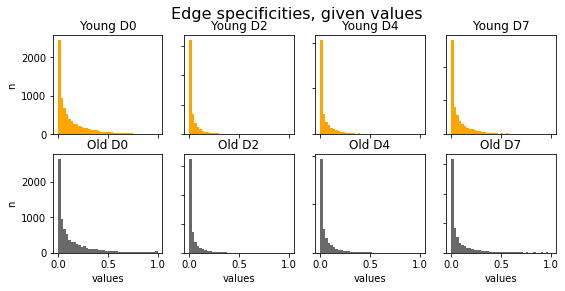

In [105]:
""" plotting edge specificities """
histocols = ['orange', 'dimgray']
fig, axs = plt.subplots(2, 4, figsize=(9,4))
for rawi in range(2):
    AGE = ages[rawi]
    for coli in range(4):
        DAY = days[coli]
        tmpvec = lr[AGE][DAY].frame['Edge average expression derived specificity']        
        axs[rawi, coli].hist(tmpvec,
                            color=histocols[rawi], bins=40)
        axs[rawi, coli].set_title(f'{ages[rawi]} {days[coli]}')
        

for ax in axs.flat:
    ax.set(xlabel='values', ylabel='n')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle(f'Edge specificities, given values', fontsize=16)

**This is very similar to TAu indexes, being 1 most specific, and 0 housekeeping !**  . Most have weak specificities, do preservative approach, by using log10 to filter. First we must explore log transformed values

Text(0.5, 0.98, 'Edge specificities, log10 (x)')

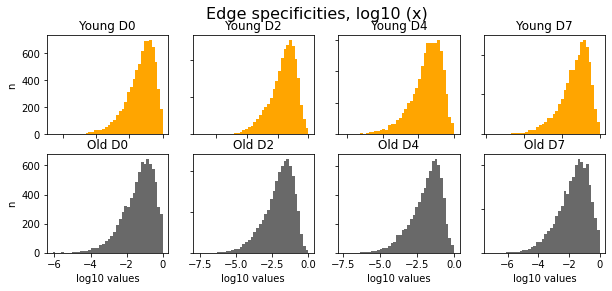

In [108]:
""" plotting edge specificities, log """

histocols = ['orange', 'dimgray']
fig, axs = plt.subplots(2, 4, figsize=(10,4))
for rawi in range(2):
    AGE = ages[rawi]
    for coli in range(4):
        DAY = days[coli]
        tmpvec = lr[AGE][DAY].frame['Edge average expression derived specificity']        
        axs[rawi, coli].hist(np.log10(np.array(tmpvec)),
                            color=histocols[rawi], bins=40)
        axs[rawi, coli].set_title(f'{ages[rawi]} {days[coli]}')        

for ax in axs.flat:
    ax.set(xlabel='log10 values', ylabel='n')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle(f'Edge specificities, log10 (x)', fontsize=16)

The closer to 1 (0 in log10 value) the more the edge is predicted to be 'specific'
We see that most of edges specificities are concentrated between 0.1 and 0.001 (-1 and -3 in log10 value). 
These plots allowed us to know about data distribution, but we need
to scale them to  values suitable for making graph style visualizations.

### filter , using function from my 'LRinfos' class : 

The function 'filterOnEdgeslog10' is defined inside the class (above), cutoff is customizable

In [118]:
## filter and check edges
for age in ages:
    for day in days:
        lr[age][day].filterOnEdgeslog10(-0.5)   # using -0.5 as log10 cutoff

In [119]:
lr['Young']['D4'].filtered['log10_edge_sp']

1       -0.226905
4       -0.209117
6       -0.096283
9       -0.047613
20      -0.451170
           ...   
18233   -0.443808
18248   -0.302185
18251   -0.482674
18277   -0.417991
18487   -0.333992
Name: log10_edge_sp, Length: 770, dtype: float64

Text(0.5, 0.98, 'Edge specificities, POST filter ')

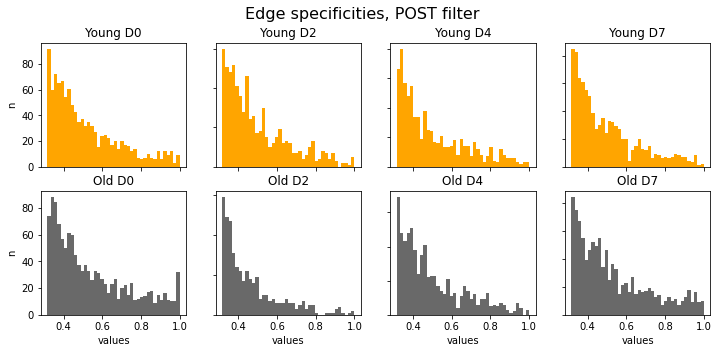

In [120]:
## plotting POST filter
""" plotting POST filter edge specificities """
histocols = ['orange', 'dimgray']
fig, axs = plt.subplots(2, 4, figsize=(12,5))
for rawi in range(2):
    AGE = ages[rawi]
    for coli in range(4):
        DAY = days[coli]
        tmpvec = lr[AGE][DAY].filtered['Edge average expression derived specificity']     
        #tmpvec = lr[AGE][DAY].filtered['log10_edge_sp']
        axs[rawi, coli].hist(np.array(tmpvec),
                            color=histocols[rawi], bins=40)
        axs[rawi, coli].set_title(f'{ages[rawi]} {days[coli]}')
        

for ax in axs.flat:
    ax.set(xlabel='values', ylabel='n')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle(f'Edge specificities, POST filter ', fontsize=16)

In [121]:
for age in ages:
    for day in days:
        print((age,day))
        print(lr[age][day].filtered.shape)

('Young', 'D0')
(1082, 15)
('Young', 'D2')
(686, 15)
('Young', 'D4')
(770, 15)
('Young', 'D7')
(904, 15)
('Old', 'D0')
(1225, 15)
('Old', 'D2')
(448, 15)
('Old', 'D4')
(706, 15)
('Old', 'D7')
(1070, 15)


That was very stringent (-0.5), let's set another cutoff

In [214]:
for age in ages:
    for day in days:
        lr[age][day].filterOnEdgeslog10(-1) 

### Compare filtered and unfiltered number of edges:
Making a simple table

In [215]:
tabularmanual = {'notfiltered' : [], 'filtered' : []}
manualindexes = []
for i in ages:
    for j in days:
        tabularmanual['notfiltered'].append(lr[i][j].frame.shape[0])
        tabularmanual['filtered'].append(lr[i][j].filtered.shape[0])
        manualindexes.append(f'{i}_{j}')
#    = {'notfiltered' : [1,2,3], 'filtered' : [4,5,6]}

In [219]:
lr['Old']['D0'].filtered.shape[0]

3220

In [220]:
print("compare unfiltered vs filtered, as filter done on edges specs")
pd.DataFrame(tabularmanual, index = manualindexes)

compare unfiltered vs filtered, as filter done on edges specs


,notfiltered,filtered
Young_D0,7735,3152
Young_D2,26045,3677
Young_D4,18490,3642
Young_D7,12725,3642
Old_D0,8038,3220
Old_D2,26725,3577
Old_D4,18547,3729
Old_D7,13354,3557


Text(0.5, 0.98, 'Edge specificities, POST filter ')

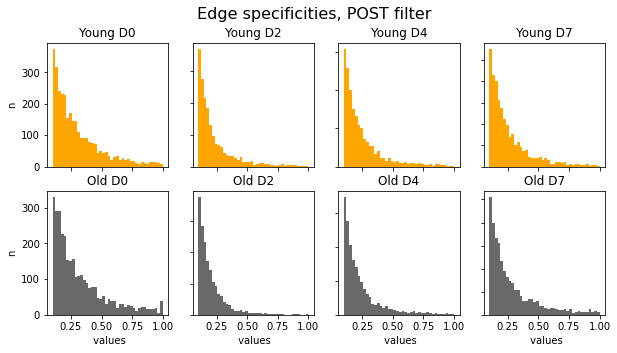

In [222]:
""" plotting POST filter edge specificities """
histocols = ['orange', 'dimgray']
fig, axs = plt.subplots(2, 4, figsize=(10,5))
for rawi in range(2):
    AGE = ages[rawi]
    for coli in range(4):
        DAY = days[coli]
        tmpvec = lr[AGE][DAY].filtered['Edge average expression derived specificity']     
        #tmpvec = lr[AGE][DAY].filtered['log10_edge_sp']
        axs[rawi, coli].hist(np.array(tmpvec),
                            color=histocols[rawi], bins=40)
        axs[rawi, coli].set_title(f'{ages[rawi]} {days[coli]}')
        

for ax in axs.flat:
    ax.set(xlabel=' values', ylabel='n')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle(f'Edge specificities, POST filter ', fontsize=16)

## New function to get Networkx object from dataframe
#### and give it colors as universally defined, from specialized color-blindness friendly palette (defined from R scripts)

In [223]:
def getCustomGraph(adf, celltycolors):
    """Inputs :  adf (a dataframe) , and
                 colors in the form of a dictionnary.
    Output:  Networkx object"""
    G = nx.DiGraph()
    for index,row in adf.iterrows():
        nodefrom = row['uniq_Ligand_symbol']
        nodeto = row['uniq_Receptor_symbol']
        celltypefrom = row['Sending cluster']
        celltypeto = row['Target cluster']
        G.add_node(nodefrom,
                    nodetype = 'sender',
                    celltype = celltypefrom,
                    genesym = row['Ligand symbol'],
                    color = celltycolors[celltypefrom],
                    averagexp = row['Ligand derived specificity of average expression value'])
        G.add_node(nodeto,
                    nodetype = 'receiver',
                    celltype = celltypeto, 
                    genesym = row['Receptor symbol'],
                    color = celltycolors[celltypeto],
                    averagexp = row['Receptor derived specificity of average expression value'])
        G.add_edge(nodefrom,nodeto, origtype = nodefrom,
                    ecolor = celltycolors[celltypefrom],
                    weight = row['Edge average expression derived specificity']) 
    return G

In [224]:
celltycolors = {
  "ECs" : "#0072B2",
  "FAPs" : "#F0E442",
  "M1" : "#D55E00",
  "M2" :  "#CC79A7",
  "Neutro" : "#009E73",
  "sCs" : "#56B4E9"
}

In [225]:
## creating new dictionnary to stock Networkx objects
dx = {}

In [226]:
## calling function iteratively while populating dictionnary
for age in ages:
    dx[age] = {}
    for day in days:
        tmpG = getCustomGraph(lr[age][day].filtered, celltycolors)
        dx[age][day] = tmpG
        

In [227]:
len(dx['Old']['D0'].nodes())

1441

## Saving pdf figures and both dictionnaries (lr and dx):
* lr : contains objects of the class 'LRinfos' which I created to stock dataframes
* dx : contains networkx objects
#### Dictionnaries lr and dx are saved into different files

In [ ]:
for age in ages:
    for day in days:        
        G = dx[age][day]
        ccc = [ i for i in nx.get_node_attributes(G, 'color').values()]
        eee = [ i for i in nx.get_edge_attributes(G, 'ecolor').values()]## do plot
        pos = nx.spring_layout(G)

        fig = plt.figure (figsize=(30,25),dpi=150)
        color_patches = []
        for key, value in celltycolors.items():
            tmppatch = mpatches.Patch(color=value, label=key)
            color_patches.append(tmppatch)

        nodes = nx.draw_networkx_nodes(G,
                                      pos,
                                      node_color = ccc, edgecolors = 'lightgray', 
                                      alpha=0.7)
        edges = nx.draw_networkx_edges(G,
                                      pos,
                                      edge_color = eee, alpha=0.7)
        ax = plt.gca()
        ax.set_axis_off()
        fig.tight_layout()
        plt.legend(handles=color_patches, prop={'size': 20})

        fig.suptitle(f'{age}, {day}. n edges:{len(G.edges())}', fontsize=22)
        fig.savefig(f'postFilterNet_{age}{day}.pdf', dpi=150)

## obtaining huge size legend for graphical editing purposes

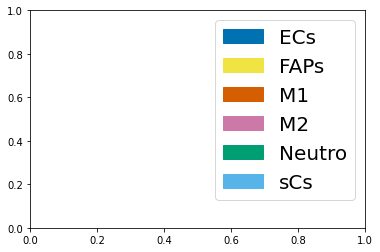

In [173]:
plt.legend(handles=color_patches, prop={'size': 20})


In [ ]:
# save both dictionnaries (lr  and dx), avoids re-calculating filters and graphs

In [196]:
pickle.dump(lr, open( "graphobjs/dictio_lr.p", "wb" ))

In [197]:
pickle.dump(dx, open( "graphobjs/dictio_dx.p", "wb" ))

In [ ]:
# to open just: lr = pickle.load( open( "graphobjs/dictio_lr.p", "rb" ) )

In [3]:
plt.close('all')